In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [53]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

#### book_title -- preprocessing

In [54]:
# type(books['book_title'][0])

In [55]:
# books['book_title']= books['book_title'].apply(lambda x: ''.join(x.split()).strip())

In [56]:
# books['book_title'].nunique()

In [57]:
# for i in range(10):
#     print(books['book_title'].apply(lambda x: ''.join(x.split()[:i]).strip()).nunique())


In [58]:
# books['book_title'].apply(lambda x: ''.join(x.split()[:2]).strip())

* 책 제목에 오타가 있었나 몇백개가 빠지는데 이유가뭘까?
* 아니면 데이터 그 자체로는  띄어쓰기가 포함되서 안좋은걸까 궁금하네

시각화 하고 싶은데 어떡하지?

In [59]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop([ 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [60]:
books['publisher'].nunique()

10267

In [61]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [62]:
books['category_high'].value_counts()

fiction                                            39678
biography autobiography                             3326
history                                             1927
religion                                            1824
nonfiction                                          1427
                                                   ...  
buddhismus                                             1
heller jettero fictitious character                    1
persian gulf                                           1
procedure law                                          1
authors canadian english 20th century biography        1
Name: category_high, Length: 3270, dtype: int64

In [63]:
books['category_high'].nunique()

3270

In [64]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [65]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [66]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [67]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [68]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


In [69]:
users['location_city'].nunique()

11995

## rating 테이블과 merge

In [70]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')

train_ratings['book_title']  = train_ratings['book_title'].astype('str')
test_ratings['book_title'] = test_ratings['book_title'].astype('str')


In [71]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 315083
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  object 
 1   isbn              306795 non-null  object 
 2   rating            306795 non-null  float64
 3   book_title        306795 non-null  object 
 4   book_author       306795 non-null  object 
 5   publisher         306795 non-null  object 
 6   language          306795 non-null  object 
 7   category_high     306795 non-null  object 
 8   years             306795 non-null  object 
 9   location_city     306795 non-null  object 
 10  location_state    306795 non-null  object 
 11  location_country  306795 non-null  object 
 12  fix_age           306795 non-null  object 
dtypes: float64(1), object(12)
memory usage: 32.8+ MB


# 모델링

In [72]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
  folds.append((train_idx,valid_idx))

In [73]:
random.seed(SEED)
cat_models={}

cat_features = list(range(1, 11))

def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 3000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(0,10):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'],axis = 1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'],axis = 1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=5)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', 
                              devices = '0', random_seed = SEED, objective = 'RMSE', 
                              cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================


[I 2022-11-03 04:44:59,138] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328872	test: 2.4328488	best: 2.4328488 (0)	total: 15.7ms	remaining: 38.6s
100:	learn: 2.4273810	test: 2.4258071	best: 2.4258071 (100)	total: 1.4s	remaining: 32.8s
200:	learn: 2.4273619	test: 2.4257088	best: 2.4257088 (200)	total: 2.74s	remaining: 30.8s
300:	learn: 2.4273615	test: 2.4257042	best: 2.4257041 (291)	total: 4.07s	remaining: 29.3s
bestTest = 2.425703788
bestIteration = 335
Shrink model to first 336 iterations.


[I 2022-11-03 04:45:07,726] Trial 0 finished with value: 2.4257039992901044 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4257039992901044.


0:	learn: 2.4331476	test: 2.4331493	best: 2.4331493 (0)	total: 14ms	remaining: 37.3s
100:	learn: 2.4292842	test: 2.4285398	best: 2.4285398 (100)	total: 1.31s	remaining: 33.4s
200:	learn: 2.4280011	test: 2.4268542	best: 2.4268542 (200)	total: 2.67s	remaining: 32.7s
300:	learn: 2.4275734	test: 2.4262058	best: 2.4262058 (300)	total: 4.02s	remaining: 31.6s
400:	learn: 2.4274320	test: 2.4259398	best: 2.4259398 (400)	total: 5.4s	remaining: 30.5s
500:	learn: 2.4273845	test: 2.4258220	best: 2.4258220 (500)	total: 6.77s	remaining: 29.3s
600:	learn: 2.4273696	test: 2.4257664	best: 2.4257664 (600)	total: 8.15s	remaining: 28s
700:	learn: 2.4273641	test: 2.4257378	best: 2.4257378 (700)	total: 9.52s	remaining: 26.7s
800:	learn: 2.4273628	test: 2.4257227	best: 2.4257227 (800)	total: 10.9s	remaining: 25.4s
900:	learn: 2.4273616	test: 2.4257144	best: 2.4257144 (900)	total: 12.3s	remaining: 24s
1000:	learn: 2.4273615	test: 2.4257102	best: 2.4257102 (998)	total: 13.6s	remaining: 22.7s
1100:	learn: 2.4273

[I 2022-11-03 04:45:47,124] Trial 1 finished with value: 2.4257041814253624 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4257039992901044.


0:	learn: 2.4095263	test: 2.4058743	best: 2.4058743 (0)	total: 28.7ms	remaining: 45.4s
100:	learn: 2.1877379	test: 2.1424945	best: 2.1424945 (100)	total: 2.73s	remaining: 40.1s
200:	learn: 2.1707356	test: 2.1338086	best: 2.1338086 (200)	total: 5.36s	remaining: 36.9s
300:	learn: 2.1538227	test: 2.1285459	best: 2.1285459 (300)	total: 7.82s	remaining: 33.3s
400:	learn: 2.1416599	test: 2.1266592	best: 2.1266592 (400)	total: 10.3s	remaining: 30.5s
500:	learn: 2.1318830	test: 2.1262132	best: 2.1261863 (495)	total: 12.9s	remaining: 27.8s
600:	learn: 2.1215270	test: 2.1251817	best: 2.1250896 (597)	total: 15.4s	remaining: 25.2s
700:	learn: 2.1123611	test: 2.1250579	best: 2.1248782 (654)	total: 17.9s	remaining: 22.6s
800:	learn: 2.1029681	test: 2.1247063	best: 2.1246269 (732)	total: 20.4s	remaining: 19.9s
900:	learn: 2.0943707	test: 2.1244791	best: 2.1243336 (870)	total: 22.8s	remaining: 17.3s
1000:	learn: 2.0856794	test: 2.1247669	best: 2.1241967 (912)	total: 25.3s	remaining: 14.7s
1100:	learn:

[I 2022-11-03 04:46:31,007] Trial 2 finished with value: 2.124196814512804 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124196814512804.


0:	learn: 2.4052905	test: 2.4006243	best: 2.4006243 (0)	total: 461ms	remaining: 8m 39s
100:	learn: 2.0508288	test: 2.1384855	best: 2.1384855 (100)	total: 46.4s	remaining: 7m 52s
200:	learn: 1.8777520	test: 2.1360092	best: 2.1351231 (197)	total: 1m 32s	remaining: 7m 5s
300:	learn: 1.4475818	test: 2.1532085	best: 2.1351231 (197)	total: 2m 18s	remaining: 6m 21s
400:	learn: 1.1601286	test: 2.1683986	best: 2.1351231 (197)	total: 3m 5s	remaining: 5m 36s
500:	learn: 0.9610630	test: 2.1807609	best: 2.1351231 (197)	total: 3m 51s	remaining: 4m 50s
600:	learn: 0.8208271	test: 2.1889159	best: 2.1351231 (197)	total: 4m 37s	remaining: 4m 4s
700:	learn: 0.7146065	test: 2.1953555	best: 2.1351231 (197)	total: 5m 23s	remaining: 3m 18s
800:	learn: 0.6145574	test: 2.2003125	best: 2.1351231 (197)	total: 6m 10s	remaining: 2m 32s
900:	learn: 0.5448913	test: 2.2038561	best: 2.1351231 (197)	total: 6m 57s	remaining: 1m 46s
1000:	learn: 0.4808019	test: 2.2078499	best: 2.1351231 (197)	total: 7m 44s	remaining: 59.

[I 2022-11-03 04:55:21,957] Trial 3 finished with value: 2.135123039741515 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124196814512804.


0:	learn: 2.4302885	test: 2.4301751	best: 2.4301751 (0)	total: 278ms	remaining: 4m 56s
100:	learn: 2.2592843	test: 2.2496505	best: 2.2496505 (100)	total: 24.6s	remaining: 3m 55s
200:	learn: 2.1914884	test: 2.1843056	best: 2.1843056 (200)	total: 49.3s	remaining: 3m 32s
300:	learn: 2.1543010	test: 2.1587896	best: 2.1587896 (300)	total: 1m 14s	remaining: 3m 9s
400:	learn: 2.1285190	test: 2.1472064	best: 2.1472064 (400)	total: 1m 39s	remaining: 2m 45s
500:	learn: 2.1094243	test: 2.1410911	best: 2.1410911 (500)	total: 2m 4s	remaining: 2m 20s
600:	learn: 2.0939802	test: 2.1372994	best: 2.1372994 (600)	total: 2m 29s	remaining: 1m 56s
700:	learn: 2.0778645	test: 2.1348157	best: 2.1348157 (700)	total: 2m 54s	remaining: 1m 31s
800:	learn: 2.0616825	test: 2.1330417	best: 2.1330417 (800)	total: 3m 19s	remaining: 1m 6s
900:	learn: 2.0487693	test: 2.1316339	best: 2.1316339 (900)	total: 3m 44s	remaining: 41.6s
1000:	learn: 2.0353801	test: 2.1303103	best: 2.1303010 (999)	total: 4m 9s	remaining: 16.7s


[I 2022-11-03 04:59:57,149] Trial 4 finished with value: 2.1296780369233743 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124196814512804.


0:	learn: 2.4095263	total: 27.8ms	remaining: 44.1s
1:	learn: 2.3890290	total: 56.1ms	remaining: 44.4s
2:	learn: 2.3701049	total: 81ms	remaining: 42.7s
3:	learn: 2.3566491	total: 107ms	remaining: 42.2s
4:	learn: 2.3429269	total: 130ms	remaining: 41.1s
5:	learn: 2.3316125	total: 157ms	remaining: 41.3s
6:	learn: 2.3215565	total: 182ms	remaining: 41s
7:	learn: 2.3140429	total: 208ms	remaining: 41.1s
8:	learn: 2.3026726	total: 237ms	remaining: 41.5s
9:	learn: 2.2949670	total: 266ms	remaining: 41.8s
10:	learn: 2.2878858	total: 296ms	remaining: 42.3s
11:	learn: 2.2803097	total: 323ms	remaining: 42.3s
12:	learn: 2.2730256	total: 351ms	remaining: 42.4s
13:	learn: 2.2672876	total: 377ms	remaining: 42.3s
14:	learn: 2.2633971	total: 406ms	remaining: 42.4s
15:	learn: 2.2590306	total: 434ms	remaining: 42.5s
16:	learn: 2.2539595	total: 461ms	remaining: 42.5s
17:	learn: 2.2499685	total: 489ms	remaining: 42.5s
18:	learn: 2.2460872	total: 518ms	remaining: 42.7s
19:	learn: 2.2424946	total: 545ms	remainin

[I 2022-11-03 05:00:41,895] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328913	test: 2.4326600	best: 2.4326600 (0)	total: 14.7ms	remaining: 36.2s
100:	learn: 2.4270869	test: 2.4259033	best: 2.4259033 (100)	total: 1.4s	remaining: 32.7s
200:	learn: 2.4270673	test: 2.4258373	best: 2.4258373 (200)	total: 2.79s	remaining: 31.4s
bestTest = 2.425834692
bestIteration = 264
Shrink model to first 265 iterations.


[I 2022-11-03 05:00:48,429] Trial 0 finished with value: 2.425834886940065 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425834886940065.


0:	learn: 2.4331652	test: 2.4329602	best: 2.4329602 (0)	total: 14.2ms	remaining: 38s
100:	learn: 2.4290938	test: 2.4284122	best: 2.4284122 (100)	total: 1.32s	remaining: 33.5s
200:	learn: 2.4277404	test: 2.4268115	best: 2.4268115 (200)	total: 2.62s	remaining: 32.1s
300:	learn: 2.4272911	test: 2.4262283	best: 2.4262283 (300)	total: 3.92s	remaining: 30.8s
400:	learn: 2.4271416	test: 2.4260054	best: 2.4260054 (400)	total: 5.22s	remaining: 29.5s
500:	learn: 2.4270923	test: 2.4259140	best: 2.4259140 (500)	total: 6.53s	remaining: 28.2s
600:	learn: 2.4270757	test: 2.4258741	best: 2.4258741 (600)	total: 7.82s	remaining: 26.9s
700:	learn: 2.4270704	test: 2.4258553	best: 2.4258553 (700)	total: 9.13s	remaining: 25.6s
800:	learn: 2.4270682	test: 2.4258457	best: 2.4258457 (800)	total: 10.4s	remaining: 24.3s
900:	learn: 2.4270678	test: 2.4258406	best: 2.4258406 (896)	total: 11.8s	remaining: 23s
1000:	learn: 2.4270676	test: 2.4258377	best: 2.4258377 (1000)	total: 13.1s	remaining: 21.7s
1100:	learn: 2.

[I 2022-11-03 05:01:26,980] Trial 1 finished with value: 2.4258347327363983 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4258347327363983.


0:	learn: 2.4099748	test: 2.4068637	best: 2.4068637 (0)	total: 31.1ms	remaining: 49.3s
100:	learn: 2.1877111	test: 2.1512629	best: 2.1512629 (100)	total: 2.99s	remaining: 43.9s
200:	learn: 2.1702072	test: 2.1423204	best: 2.1423204 (200)	total: 5.65s	remaining: 38.8s
300:	learn: 2.1532651	test: 2.1363889	best: 2.1363849 (299)	total: 8.16s	remaining: 34.8s
400:	learn: 2.1405978	test: 2.1347198	best: 2.1347105 (395)	total: 10.8s	remaining: 31.8s
500:	learn: 2.1297282	test: 2.1334292	best: 2.1334292 (500)	total: 13.4s	remaining: 29s
600:	learn: 2.1196753	test: 2.1328771	best: 2.1328771 (600)	total: 16s	remaining: 26.2s
700:	learn: 2.1099055	test: 2.1329742	best: 2.1326851 (628)	total: 18.6s	remaining: 23.5s
800:	learn: 2.1000997	test: 2.1324772	best: 2.1324772 (800)	total: 21.2s	remaining: 20.7s
900:	learn: 2.0912783	test: 2.1321044	best: 2.1320004 (870)	total: 23.7s	remaining: 18s
1000:	learn: 2.0827778	test: 2.1323914	best: 2.1320004 (870)	total: 26.2s	remaining: 15.2s
1100:	learn: 2.074

[I 2022-11-03 05:02:11,265] Trial 2 finished with value: 2.1320003967769634 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1320003967769634.


0:	learn: 2.4057637	test: 2.4032288	best: 2.4032288 (0)	total: 461ms	remaining: 8m 40s
100:	learn: 2.0314912	test: 2.1490648	best: 2.1490648 (100)	total: 46s	remaining: 7m 48s
200:	learn: 1.8440588	test: 2.1499258	best: 2.1471488 (173)	total: 1m 31s	remaining: 7m 2s
300:	learn: 1.3975633	test: 2.1790238	best: 2.1471488 (173)	total: 2m 17s	remaining: 6m 19s
400:	learn: 1.1246412	test: 2.1954373	best: 2.1471488 (173)	total: 3m 4s	remaining: 5m 34s
500:	learn: 0.9503134	test: 2.2052629	best: 2.1471488 (173)	total: 3m 49s	remaining: 4m 48s
600:	learn: 0.8049827	test: 2.2120062	best: 2.1471488 (173)	total: 4m 35s	remaining: 4m 2s
700:	learn: 0.6981552	test: 2.2173093	best: 2.1471488 (173)	total: 5m 21s	remaining: 3m 16s
800:	learn: 0.6098661	test: 2.2211494	best: 2.1471488 (173)	total: 6m 7s	remaining: 2m 30s
900:	learn: 0.5363778	test: 2.2246167	best: 2.1471488 (173)	total: 6m 52s	remaining: 1m 44s
1000:	learn: 0.4751647	test: 2.2269775	best: 2.1471488 (173)	total: 7m 38s	remaining: 59.1s


[I 2022-11-03 05:10:53,975] Trial 3 finished with value: 2.1471488357896775 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1320003967769634.


0:	learn: 2.4303000	test: 2.4299525	best: 2.4299525 (0)	total: 247ms	remaining: 4m 23s
100:	learn: 2.2559324	test: 2.2525746	best: 2.2525746 (100)	total: 24.7s	remaining: 3m 56s
200:	learn: 2.1857041	test: 2.1914324	best: 2.1914324 (200)	total: 49.3s	remaining: 3m 32s
300:	learn: 2.1481441	test: 2.1657128	best: 2.1657128 (300)	total: 1m 13s	remaining: 3m 8s
400:	learn: 2.1215429	test: 2.1544262	best: 2.1544262 (400)	total: 1m 39s	remaining: 2m 44s
500:	learn: 2.1005797	test: 2.1485026	best: 2.1485026 (500)	total: 2m 4s	remaining: 2m 20s
600:	learn: 2.0836627	test: 2.1446443	best: 2.1446443 (600)	total: 2m 29s	remaining: 1m 55s
700:	learn: 2.0670512	test: 2.1421095	best: 2.1421095 (700)	total: 2m 54s	remaining: 1m 31s
800:	learn: 2.0508092	test: 2.1403312	best: 2.1403312 (800)	total: 3m 19s	remaining: 1m 6s
900:	learn: 2.0348601	test: 2.1386178	best: 2.1386178 (900)	total: 3m 44s	remaining: 41.6s
1000:	learn: 2.0186157	test: 2.1376299	best: 2.1376299 (1000)	total: 4m 9s	remaining: 16.7s

[I 2022-11-03 05:15:30,044] Trial 4 finished with value: 2.1371997907521743 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1320003967769634.


0:	learn: 2.4099748	total: 27.5ms	remaining: 43.5s
1:	learn: 2.3894701	total: 55.5ms	remaining: 43.9s
2:	learn: 2.3702547	total: 80.1ms	remaining: 42.2s
3:	learn: 2.3566545	total: 106ms	remaining: 41.8s
4:	learn: 2.3430169	total: 129ms	remaining: 40.7s
5:	learn: 2.3319163	total: 155ms	remaining: 40.7s
6:	learn: 2.3219987	total: 179ms	remaining: 40.3s
7:	learn: 2.3144025	total: 205ms	remaining: 40.3s
8:	learn: 2.3046673	total: 231ms	remaining: 40.4s
9:	learn: 2.2968553	total: 259ms	remaining: 40.7s
10:	learn: 2.2895013	total: 288ms	remaining: 41.2s
11:	learn: 2.2818529	total: 315ms	remaining: 41.2s
12:	learn: 2.2749194	total: 341ms	remaining: 41.2s
13:	learn: 2.2694891	total: 367ms	remaining: 41.1s
14:	learn: 2.2655875	total: 394ms	remaining: 41.2s
15:	learn: 2.2610884	total: 421ms	remaining: 41.3s
16:	learn: 2.2555723	total: 446ms	remaining: 41.1s
17:	learn: 2.2515565	total: 473ms	remaining: 41.2s
18:	learn: 2.2475176	total: 503ms	remaining: 41.4s
19:	learn: 2.2439855	total: 529ms	rema

[I 2022-11-03 05:16:13,311] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328528	test: 2.4329075	best: 2.4329075 (0)	total: 14.2ms	remaining: 34.9s
100:	learn: 2.4268485	test: 2.4265645	best: 2.4265645 (100)	total: 1.35s	remaining: 31.7s
200:	learn: 2.4268278	test: 2.4265341	best: 2.4265341 (197)	total: 2.67s	remaining: 30.1s
bestTest = 2.426533705
bestIteration = 214
Shrink model to first 215 iterations.


[I 2022-11-03 05:16:19,228] Trial 0 finished with value: 2.426533852497375 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426533852497375.


0:	learn: 2.4331351	test: 2.4332023	best: 2.4332023 (0)	total: 14.7ms	remaining: 39.1s
100:	learn: 2.4289246	test: 2.4287929	best: 2.4287929 (100)	total: 1.43s	remaining: 36.3s
200:	learn: 2.4275242	test: 2.4273088	best: 2.4273088 (200)	total: 2.8s	remaining: 34.4s
300:	learn: 2.4270593	test: 2.4268053	best: 2.4268053 (300)	total: 4.17s	remaining: 32.8s
400:	learn: 2.4269049	test: 2.4266319	best: 2.4266319 (400)	total: 5.55s	remaining: 31.3s
500:	learn: 2.4268540	test: 2.4265710	best: 2.4265710 (500)	total: 6.93s	remaining: 29.9s
600:	learn: 2.4268362	test: 2.4265485	best: 2.4265485 (600)	total: 8.31s	remaining: 28.5s
700:	learn: 2.4268306	test: 2.4265401	best: 2.4265401 (698)	total: 9.68s	remaining: 27.1s
800:	learn: 2.4268292	test: 2.4265365	best: 2.4265364 (798)	total: 11.1s	remaining: 25.7s
900:	learn: 2.4268283	test: 2.4265352	best: 2.4265350 (897)	total: 12.4s	remaining: 24.3s
1000:	learn: 2.4268276	test: 2.4265342	best: 2.4265342 (988)	total: 13.8s	remaining: 22.9s
1100:	learn: 

[I 2022-11-03 05:16:58,907] Trial 1 finished with value: 2.42653366123187 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.42653366123187.


0:	learn: 2.4093967	test: 2.4066778	best: 2.4066778 (0)	total: 30.5ms	remaining: 48.3s
100:	learn: 2.1874047	test: 2.1546874	best: 2.1546874 (100)	total: 2.84s	remaining: 41.7s
200:	learn: 2.1699019	test: 2.1452674	best: 2.1452674 (200)	total: 5.62s	remaining: 38.7s
300:	learn: 2.1529100	test: 2.1402811	best: 2.1402276 (298)	total: 8.12s	remaining: 34.6s
400:	learn: 2.1407353	test: 2.1381462	best: 2.1381462 (400)	total: 10.7s	remaining: 31.6s
500:	learn: 2.1304144	test: 2.1365655	best: 2.1365195 (496)	total: 13.3s	remaining: 28.7s
600:	learn: 2.1201003	test: 2.1362557	best: 2.1361403 (587)	total: 15.8s	remaining: 25.9s
700:	learn: 2.1108235	test: 2.1358650	best: 2.1357508 (687)	total: 18.4s	remaining: 23.2s
800:	learn: 2.1014177	test: 2.1353168	best: 2.1352357 (790)	total: 21s	remaining: 20.5s
900:	learn: 2.0926092	test: 2.1350487	best: 2.1350487 (900)	total: 23.6s	remaining: 17.9s
1000:	learn: 2.0844634	test: 2.1351060	best: 2.1349129 (927)	total: 26.4s	remaining: 15.4s
1100:	learn: 2

[I 2022-11-03 05:17:43,868] Trial 2 finished with value: 2.1342184260915054 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1342184260915054.


0:	learn: 2.4056128	test: 2.4032856	best: 2.4032856 (0)	total: 459ms	remaining: 8m 38s
100:	learn: 2.0383805	test: 2.1488100	best: 2.1487508 (98)	total: 45.9s	remaining: 7m 47s
200:	learn: 1.8605159	test: 2.1444095	best: 2.1442252 (195)	total: 1m 31s	remaining: 7m 2s
300:	learn: 1.4109956	test: 2.1616304	best: 2.1442252 (195)	total: 2m 17s	remaining: 6m 19s
400:	learn: 1.1352246	test: 2.1771118	best: 2.1442252 (195)	total: 3m 4s	remaining: 5m 34s
500:	learn: 0.9521944	test: 2.1885578	best: 2.1442252 (195)	total: 3m 50s	remaining: 4m 48s
600:	learn: 0.7893539	test: 2.1977476	best: 2.1442252 (195)	total: 4m 36s	remaining: 4m 3s
700:	learn: 0.6883490	test: 2.2036489	best: 2.1442252 (195)	total: 5m 22s	remaining: 3m 17s
800:	learn: 0.6009604	test: 2.2088204	best: 2.1442252 (195)	total: 6m 8s	remaining: 2m 31s
900:	learn: 0.5298236	test: 2.2129761	best: 2.1442252 (195)	total: 6m 55s	remaining: 1m 45s
1000:	learn: 0.4731845	test: 2.2159425	best: 2.1442252 (195)	total: 7m 41s	remaining: 59.5s

[I 2022-11-03 05:26:30,498] Trial 3 finished with value: 2.1442250460703374 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1342184260915054.


0:	learn: 2.4302332	test: 2.4301634	best: 2.4301634 (0)	total: 285ms	remaining: 5m 3s
100:	learn: 2.2566522	test: 2.2549140	best: 2.2549140 (100)	total: 25s	remaining: 3m 59s
200:	learn: 2.1866018	test: 2.1919622	best: 2.1919622 (200)	total: 49.7s	remaining: 3m 34s
300:	learn: 2.1496464	test: 2.1674417	best: 2.1674417 (300)	total: 1m 15s	remaining: 3m 11s
400:	learn: 2.1238921	test: 2.1558811	best: 2.1558811 (400)	total: 1m 40s	remaining: 2m 47s
500:	learn: 2.1058855	test: 2.1498722	best: 2.1498722 (500)	total: 2m 6s	remaining: 2m 23s
600:	learn: 2.0892135	test: 2.1461776	best: 2.1461776 (600)	total: 2m 32s	remaining: 1m 58s
700:	learn: 2.0735412	test: 2.1438810	best: 2.1438809 (699)	total: 2m 57s	remaining: 1m 32s
800:	learn: 2.0583308	test: 2.1421735	best: 2.1421735 (800)	total: 3m 22s	remaining: 1m 7s
900:	learn: 2.0431576	test: 2.1405968	best: 2.1405900 (899)	total: 3m 47s	remaining: 42.1s
1000:	learn: 2.0291087	test: 2.1393408	best: 2.1393408 (1000)	total: 4m 12s	remaining: 16.9s


[I 2022-11-03 05:31:09,458] Trial 4 finished with value: 2.1387566657848076 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1342184260915054.


0:	learn: 2.4093967	total: 29.3ms	remaining: 46.3s
1:	learn: 2.3888417	total: 59.8ms	remaining: 47.3s
2:	learn: 2.3696780	total: 84.8ms	remaining: 44.7s
3:	learn: 2.3564710	total: 111ms	remaining: 43.9s
4:	learn: 2.3428699	total: 136ms	remaining: 42.9s
5:	learn: 2.3315706	total: 163ms	remaining: 43s
6:	learn: 2.3211866	total: 189ms	remaining: 42.7s
7:	learn: 2.3137287	total: 217ms	remaining: 42.8s
8:	learn: 2.3025378	total: 247ms	remaining: 43.1s
9:	learn: 2.2964466	total: 276ms	remaining: 43.4s
10:	learn: 2.2891254	total: 306ms	remaining: 43.7s
11:	learn: 2.2810055	total: 329ms	remaining: 43.1s
12:	learn: 2.2735109	total: 358ms	remaining: 43.2s
13:	learn: 2.2688371	total: 385ms	remaining: 43.2s
14:	learn: 2.2648189	total: 414ms	remaining: 43.4s
15:	learn: 2.2600185	total: 443ms	remaining: 43.4s
16:	learn: 2.2544186	total: 469ms	remaining: 43.3s
17:	learn: 2.2501995	total: 497ms	remaining: 43.2s
18:	learn: 2.2461633	total: 528ms	remaining: 43.5s
19:	learn: 2.2423067	total: 554ms	remain

[I 2022-11-03 05:31:54,295] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328723	test: 2.4329150	best: 2.4329150 (0)	total: 18.4ms	remaining: 45.3s
100:	learn: 2.4272033	test: 2.4264905	best: 2.4264905 (100)	total: 1.46s	remaining: 34.2s
200:	learn: 2.4271840	test: 2.4264357	best: 2.4264357 (200)	total: 2.92s	remaining: 32.9s
300:	learn: 2.4271844	test: 2.4264337	best: 2.4264337 (281)	total: 4.35s	remaining: 31.3s
bestTest = 2.426433693
bestIteration = 281
Shrink model to first 282 iterations.


[I 2022-11-03 05:32:01,395] Trial 0 finished with value: 2.426433748957791 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426433748957791.


0:	learn: 2.4331395	test: 2.4332040	best: 2.4332040 (0)	total: 15ms	remaining: 40s
100:	learn: 2.4291631	test: 2.4288425	best: 2.4288425 (100)	total: 1.49s	remaining: 37.9s
200:	learn: 2.4278416	test: 2.4273255	best: 2.4273255 (200)	total: 2.9s	remaining: 35.6s
300:	learn: 2.4274024	test: 2.4267826	best: 2.4267826 (300)	total: 4.21s	remaining: 33.1s
400:	learn: 2.4272567	test: 2.4265799	best: 2.4265799 (400)	total: 5.52s	remaining: 31.2s
500:	learn: 2.4272082	test: 2.4264996	best: 2.4264996 (500)	total: 6.79s	remaining: 29.3s
600:	learn: 2.4271923	test: 2.4264655	best: 2.4264655 (600)	total: 8.06s	remaining: 27.7s
700:	learn: 2.4271868	test: 2.4264502	best: 2.4264501 (699)	total: 9.33s	remaining: 26.1s
800:	learn: 2.4271852	test: 2.4264425	best: 2.4264424 (799)	total: 10.6s	remaining: 24.7s
900:	learn: 2.4271840	test: 2.4264384	best: 2.4264384 (900)	total: 11.9s	remaining: 23.4s
1000:	learn: 2.4271848	test: 2.4264362	best: 2.4264362 (991)	total: 13.3s	remaining: 22s
1100:	learn: 2.4271

[I 2022-11-03 05:32:39,683] Trial 1 finished with value: 2.426433704326849 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426433704326849.


0:	learn: 2.4096422	test: 2.4065365	best: 2.4065365 (0)	total: 31.9ms	remaining: 50.5s
100:	learn: 2.1883962	test: 2.1464752	best: 2.1464697 (99)	total: 2.92s	remaining: 42.9s
200:	learn: 2.1710198	test: 2.1378257	best: 2.1378257 (200)	total: 5.76s	remaining: 39.7s
300:	learn: 2.1540128	test: 2.1324205	best: 2.1324205 (300)	total: 8.3s	remaining: 35.4s
400:	learn: 2.1420651	test: 2.1305568	best: 2.1305042 (398)	total: 10.8s	remaining: 31.9s
500:	learn: 2.1304619	test: 2.1286902	best: 2.1286902 (500)	total: 13.3s	remaining: 28.9s
600:	learn: 2.1203481	test: 2.1283171	best: 2.1282079 (579)	total: 15.9s	remaining: 26s
700:	learn: 2.1104681	test: 2.1278050	best: 2.1278050 (700)	total: 18.5s	remaining: 23.3s
800:	learn: 2.1010611	test: 2.1276413	best: 2.1276413 (800)	total: 21.1s	remaining: 20.6s
900:	learn: 2.0920010	test: 2.1272059	best: 2.1271365 (885)	total: 23.7s	remaining: 18s
1000:	learn: 2.0833171	test: 2.1271841	best: 2.1268705 (958)	total: 26.4s	remaining: 15.4s
1100:	learn: 2.074

[I 2022-11-03 05:33:25,562] Trial 2 finished with value: 2.1268469878761214 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268469878761214.


0:	learn: 2.4048220	test: 2.4019749	best: 2.4019749 (0)	total: 459ms	remaining: 8m 38s
100:	learn: 2.0424477	test: 2.1415146	best: 2.1414568 (97)	total: 46.3s	remaining: 7m 51s
200:	learn: 1.8633883	test: 2.1369324	best: 2.1363557 (187)	total: 1m 32s	remaining: 7m 5s
300:	learn: 1.4269893	test: 2.1515858	best: 2.1363557 (187)	total: 2m 18s	remaining: 6m 22s
400:	learn: 1.1572639	test: 2.1658109	best: 2.1363557 (187)	total: 3m 5s	remaining: 5m 37s
500:	learn: 0.9574494	test: 2.1767610	best: 2.1363557 (187)	total: 3m 51s	remaining: 4m 51s
600:	learn: 0.8190779	test: 2.1864853	best: 2.1363557 (187)	total: 4m 38s	remaining: 4m 5s
700:	learn: 0.7036877	test: 2.1933281	best: 2.1363557 (187)	total: 5m 24s	remaining: 3m 18s
800:	learn: 0.6206620	test: 2.1980663	best: 2.1363557 (187)	total: 6m 11s	remaining: 2m 32s
900:	learn: 0.5461729	test: 2.2026964	best: 2.1363557 (187)	total: 6m 57s	remaining: 1m 46s
1000:	learn: 0.4871443	test: 2.2062070	best: 2.1363557 (187)	total: 7m 43s	remaining: 59.7

[I 2022-11-03 05:42:14,178] Trial 3 finished with value: 2.13635567737646 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268469878761214.


0:	learn: 2.4302278	test: 2.4300788	best: 2.4300788 (0)	total: 266ms	remaining: 4m 43s
100:	learn: 2.2559589	test: 2.2517324	best: 2.2517324 (100)	total: 24.5s	remaining: 3m 54s
200:	learn: 2.1861107	test: 2.1895999	best: 2.1895999 (200)	total: 49.1s	remaining: 3m 31s
300:	learn: 2.1489463	test: 2.1640961	best: 2.1640961 (300)	total: 1m 13s	remaining: 3m 7s
400:	learn: 2.1231016	test: 2.1522384	best: 2.1522384 (400)	total: 1m 38s	remaining: 2m 43s
500:	learn: 2.1030817	test: 2.1463892	best: 2.1463892 (500)	total: 2m 3s	remaining: 2m 19s
600:	learn: 2.0851964	test: 2.1422670	best: 2.1422670 (600)	total: 2m 28s	remaining: 1m 55s
700:	learn: 2.0705897	test: 2.1395900	best: 2.1395900 (700)	total: 2m 53s	remaining: 1m 30s
800:	learn: 2.0542245	test: 2.1375557	best: 2.1375557 (800)	total: 3m 17s	remaining: 1m 5s
900:	learn: 2.0401538	test: 2.1360340	best: 2.1360340 (900)	total: 3m 42s	remaining: 41.2s
1000:	learn: 2.0257483	test: 2.1346499	best: 2.1346499 (1000)	total: 4m 7s	remaining: 16.6s

[I 2022-11-03 05:46:47,574] Trial 4 finished with value: 2.1338949377784666 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1268469878761214.


0:	learn: 2.4096422	total: 28.3ms	remaining: 44.8s
1:	learn: 2.3910644	total: 54.8ms	remaining: 43.3s
2:	learn: 2.3717433	total: 79.9ms	remaining: 42.1s
3:	learn: 2.3577820	total: 106ms	remaining: 41.8s
4:	learn: 2.3434157	total: 129ms	remaining: 40.7s
5:	learn: 2.3321156	total: 155ms	remaining: 40.9s
6:	learn: 2.3220963	total: 180ms	remaining: 40.6s
7:	learn: 2.3147762	total: 206ms	remaining: 40.7s
8:	learn: 2.3050380	total: 233ms	remaining: 40.9s
9:	learn: 2.2972881	total: 262ms	remaining: 41.2s
10:	learn: 2.2900533	total: 292ms	remaining: 41.8s
11:	learn: 2.2821865	total: 319ms	remaining: 41.8s
12:	learn: 2.2746400	total: 348ms	remaining: 42s
13:	learn: 2.2698565	total: 374ms	remaining: 41.9s
14:	learn: 2.2658063	total: 402ms	remaining: 42.1s
15:	learn: 2.2610945	total: 430ms	remaining: 42.1s
16:	learn: 2.2555451	total: 456ms	remaining: 42s
17:	learn: 2.2514918	total: 483ms	remaining: 42s
18:	learn: 2.2476734	total: 512ms	remaining: 42.2s
19:	learn: 2.2438157	total: 538ms	remaining:

[I 2022-11-03 05:47:31,504] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328796	test: 2.4328956	best: 2.4328956 (0)	total: 15.3ms	remaining: 37.7s
100:	learn: 2.4273314	test: 2.4257317	best: 2.4257317 (100)	total: 1.33s	remaining: 31.1s
200:	learn: 2.4273126	test: 2.4256282	best: 2.4256282 (199)	total: 2.64s	remaining: 29.7s
300:	learn: 2.4273120	test: 2.4256232	best: 2.4256232 (300)	total: 3.96s	remaining: 28.5s
bestTest = 2.425622849
bestIteration = 341
Shrink model to first 342 iterations.


[I 2022-11-03 05:47:39,120] Trial 0 finished with value: 2.4256230293338255 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4256230293338255.


0:	learn: 2.4331410	test: 2.4331999	best: 2.4331999 (0)	total: 14.8ms	remaining: 39.4s
100:	learn: 2.4292493	test: 2.4285263	best: 2.4285263 (100)	total: 1.38s	remaining: 35.1s
200:	learn: 2.4279558	test: 2.4268092	best: 2.4268092 (200)	total: 2.79s	remaining: 34.3s
300:	learn: 2.4275258	test: 2.4261448	best: 2.4261448 (300)	total: 4.21s	remaining: 33s
400:	learn: 2.4273836	test: 2.4258701	best: 2.4258701 (400)	total: 5.55s	remaining: 31.4s
500:	learn: 2.4273361	test: 2.4257474	best: 2.4257474 (500)	total: 6.89s	remaining: 29.8s
600:	learn: 2.4273204	test: 2.4256887	best: 2.4256887 (600)	total: 8.25s	remaining: 28.3s
700:	learn: 2.4273151	test: 2.4256589	best: 2.4256589 (700)	total: 9.59s	remaining: 26.9s
800:	learn: 2.4273135	test: 2.4256429	best: 2.4256429 (800)	total: 10.9s	remaining: 25.5s
900:	learn: 2.4273129	test: 2.4256343	best: 2.4256343 (897)	total: 12.3s	remaining: 24.1s
1000:	learn: 2.4273127	test: 2.4256295	best: 2.4256294 (997)	total: 13.8s	remaining: 22.9s
1100:	learn: 2

[I 2022-11-03 05:48:19,856] Trial 1 finished with value: 2.425623436810269 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4256230293338255.


0:	learn: 2.4101070	test: 2.4068611	best: 2.4068611 (0)	total: 32.7ms	remaining: 51.8s
100:	learn: 2.1878821	test: 2.1523180	best: 2.1523180 (100)	total: 3.08s	remaining: 45.2s
200:	learn: 2.1710435	test: 2.1442014	best: 2.1442014 (200)	total: 6.11s	remaining: 42.1s
300:	learn: 2.1542938	test: 2.1400914	best: 2.1400914 (300)	total: 8.82s	remaining: 37.6s
400:	learn: 2.1424172	test: 2.1388941	best: 2.1388941 (400)	total: 11.5s	remaining: 34.1s
500:	learn: 2.1313423	test: 2.1380019	best: 2.1380019 (500)	total: 14.3s	remaining: 30.9s
600:	learn: 2.1214866	test: 2.1375868	best: 2.1375868 (600)	total: 17s	remaining: 27.9s
700:	learn: 2.1119039	test: 2.1366588	best: 2.1366251 (698)	total: 19.8s	remaining: 24.9s
800:	learn: 2.1028835	test: 2.1365310	best: 2.1364623 (726)	total: 22.5s	remaining: 22s
900:	learn: 2.0944944	test: 2.1363464	best: 2.1363165 (891)	total: 25.3s	remaining: 19.2s
1000:	learn: 2.0865579	test: 2.1365114	best: 2.1361604 (950)	total: 28s	remaining: 16.3s
1100:	learn: 2.078

[I 2022-11-03 05:49:07,799] Trial 2 finished with value: 2.135193871858362 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135193871858362.


0:	learn: 2.4061455	test: 2.4035900	best: 2.4035900 (0)	total: 456ms	remaining: 8m 34s
100:	learn: 2.0381504	test: 2.1469053	best: 2.1468908 (99)	total: 46s	remaining: 7m 48s
200:	learn: 1.8566508	test: 2.1444369	best: 2.1431738 (194)	total: 1m 31s	remaining: 7m 3s
300:	learn: 1.4695425	test: 2.1694700	best: 2.1431738 (194)	total: 2m 18s	remaining: 6m 20s
400:	learn: 1.1932955	test: 2.1888053	best: 2.1431738 (194)	total: 3m 4s	remaining: 5m 35s
500:	learn: 1.0127740	test: 2.2011162	best: 2.1431738 (194)	total: 3m 50s	remaining: 4m 49s
600:	learn: 0.8771983	test: 2.2089497	best: 2.1431738 (194)	total: 4m 36s	remaining: 4m 3s
700:	learn: 0.7558821	test: 2.2176138	best: 2.1431738 (194)	total: 5m 23s	remaining: 3m 17s
800:	learn: 0.6800721	test: 2.2221536	best: 2.1431738 (194)	total: 6m 8s	remaining: 2m 31s
900:	learn: 0.6047957	test: 2.2259871	best: 2.1431738 (194)	total: 6m 54s	remaining: 1m 45s
1000:	learn: 0.5465800	test: 2.2283069	best: 2.1431738 (194)	total: 7m 40s	remaining: 59.4s
1

[I 2022-11-03 05:57:53,561] Trial 3 finished with value: 2.1431736514062503 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135193871858362.


0:	learn: 2.4303268	test: 2.4302347	best: 2.4302347 (0)	total: 273ms	remaining: 4m 51s
100:	learn: 2.2586891	test: 2.2542859	best: 2.2542859 (100)	total: 24.5s	remaining: 3m 54s
200:	learn: 2.1905978	test: 2.1917711	best: 2.1917711 (200)	total: 48.9s	remaining: 3m 30s
300:	learn: 2.1540483	test: 2.1664762	best: 2.1664762 (300)	total: 1m 13s	remaining: 3m 7s
400:	learn: 2.1284397	test: 2.1549265	best: 2.1549265 (400)	total: 1m 38s	remaining: 2m 43s
500:	learn: 2.1094046	test: 2.1490879	best: 2.1490879 (500)	total: 2m 2s	remaining: 2m 18s
600:	learn: 2.0922483	test: 2.1454198	best: 2.1454198 (600)	total: 2m 27s	remaining: 1m 54s
700:	learn: 2.0764180	test: 2.1427830	best: 2.1427830 (700)	total: 2m 52s	remaining: 1m 30s
800:	learn: 2.0599756	test: 2.1408342	best: 2.1408342 (800)	total: 3m 17s	remaining: 1m 5s
900:	learn: 2.0453542	test: 2.1394220	best: 2.1394155 (897)	total: 3m 41s	remaining: 41.1s
1000:	learn: 2.0307718	test: 2.1382259	best: 2.1382259 (1000)	total: 4m 6s	remaining: 16.5s

[I 2022-11-03 06:02:25,497] Trial 4 finished with value: 2.1375228881073283 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135193871858362.


0:	learn: 2.4101070	total: 29.4ms	remaining: 46.5s
1:	learn: 2.3895076	total: 59ms	remaining: 46.7s
2:	learn: 2.3702295	total: 85ms	remaining: 44.8s
3:	learn: 2.3566630	total: 112ms	remaining: 44.2s
4:	learn: 2.3431786	total: 136ms	remaining: 42.9s
5:	learn: 2.3319365	total: 164ms	remaining: 43s
6:	learn: 2.3215977	total: 189ms	remaining: 42.5s
7:	learn: 2.3143094	total: 216ms	remaining: 42.6s
8:	learn: 2.3045629	total: 245ms	remaining: 42.9s
9:	learn: 2.2969513	total: 274ms	remaining: 43.1s
10:	learn: 2.2896638	total: 305ms	remaining: 43.6s
11:	learn: 2.2820443	total: 334ms	remaining: 43.7s
12:	learn: 2.2748748	total: 363ms	remaining: 43.8s
13:	learn: 2.2702548	total: 389ms	remaining: 43.6s
14:	learn: 2.2661255	total: 418ms	remaining: 43.8s
15:	learn: 2.2616086	total: 447ms	remaining: 43.8s
16:	learn: 2.2561437	total: 475ms	remaining: 43.8s
17:	learn: 2.2520527	total: 503ms	remaining: 43.8s
18:	learn: 2.2480524	total: 534ms	remaining: 43.9s
19:	learn: 2.2443044	total: 560ms	remaining:

[I 2022-11-03 06:03:09,072] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328599	test: 2.4329073	best: 2.4329073 (0)	total: 14.6ms	remaining: 36s
100:	learn: 2.4269886	test: 2.4262010	best: 2.4262010 (100)	total: 1.4s	remaining: 32.7s
200:	learn: 2.4269685	test: 2.4261421	best: 2.4261421 (200)	total: 2.77s	remaining: 31.2s
bestTest = 2.426140006
bestIteration = 260
Shrink model to first 261 iterations.


[I 2022-11-03 06:03:15,667] Trial 0 finished with value: 2.4261402343756924 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4261402343756924.


0:	learn: 2.4331363	test: 2.4332080	best: 2.4332080 (0)	total: 14.7ms	remaining: 39.1s
100:	learn: 2.4290187	test: 2.4286648	best: 2.4286648 (100)	total: 1.38s	remaining: 35.1s
200:	learn: 2.4276495	test: 2.4270798	best: 2.4270798 (200)	total: 2.76s	remaining: 33.9s
300:	learn: 2.4271950	test: 2.4265105	best: 2.4265105 (300)	total: 4.13s	remaining: 32.5s
400:	learn: 2.4270439	test: 2.4262964	best: 2.4262964 (400)	total: 5.51s	remaining: 31.1s
500:	learn: 2.4269934	test: 2.4262111	best: 2.4262111 (500)	total: 6.88s	remaining: 29.7s
600:	learn: 2.4269769	test: 2.4261745	best: 2.4261745 (600)	total: 8.17s	remaining: 28.1s
700:	learn: 2.4269712	test: 2.4261576	best: 2.4261576 (700)	total: 9.48s	remaining: 26.6s
800:	learn: 2.4269694	test: 2.4261495	best: 2.4261495 (799)	total: 10.8s	remaining: 25.1s
900:	learn: 2.4269692	test: 2.4261453	best: 2.4261451 (894)	total: 12.1s	remaining: 23.6s
1000:	learn: 2.4269688	test: 2.4261428	best: 2.4261427 (999)	total: 13.4s	remaining: 22.2s
1100:	learn:

[I 2022-11-03 06:03:55,187] Trial 1 finished with value: 2.4261400426743496 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4261400426743496.


0:	learn: 2.4096753	test: 2.4063957	best: 2.4063957 (0)	total: 28.7ms	remaining: 45.4s
100:	learn: 2.1877126	test: 2.1418051	best: 2.1418051 (100)	total: 2.71s	remaining: 39.8s
200:	learn: 2.1709895	test: 2.1327774	best: 2.1327774 (200)	total: 5.31s	remaining: 36.6s
300:	learn: 2.1541644	test: 2.1277120	best: 2.1277120 (300)	total: 7.65s	remaining: 32.6s
400:	learn: 2.1416336	test: 2.1255136	best: 2.1254745 (395)	total: 10s	remaining: 29.5s
500:	learn: 2.1307748	test: 2.1244695	best: 2.1243832 (492)	total: 12.5s	remaining: 27.1s
600:	learn: 2.1211856	test: 2.1235645	best: 2.1235241 (597)	total: 15.1s	remaining: 24.8s
700:	learn: 2.1111300	test: 2.1230022	best: 2.1229301 (697)	total: 17.7s	remaining: 22.3s
800:	learn: 2.1023508	test: 2.1225606	best: 2.1225003 (776)	total: 20.3s	remaining: 19.8s
900:	learn: 2.0937711	test: 2.1223884	best: 2.1222499 (881)	total: 22.8s	remaining: 17.3s
1000:	learn: 2.0850582	test: 2.1226656	best: 2.1222499 (881)	total: 25.2s	remaining: 14.7s
1100:	learn: 2

[I 2022-11-03 06:04:42,568] Trial 2 finished with value: 2.12224995164442 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12224995164442.


0:	learn: 2.4052403	test: 2.4030000	best: 2.4030000 (0)	total: 496ms	remaining: 9m 19s
100:	learn: 2.0417234	test: 2.1377666	best: 2.1377666 (100)	total: 46.2s	remaining: 7m 50s
200:	learn: 1.8640556	test: 2.1328886	best: 2.1323031 (185)	total: 1m 32s	remaining: 7m 5s
300:	learn: 1.4677783	test: 2.1478249	best: 2.1323031 (185)	total: 2m 18s	remaining: 6m 20s
400:	learn: 1.1876559	test: 2.1645505	best: 2.1323031 (185)	total: 3m 4s	remaining: 5m 35s
500:	learn: 1.0154752	test: 2.1757251	best: 2.1323031 (185)	total: 3m 50s	remaining: 4m 49s
600:	learn: 0.8736236	test: 2.1850272	best: 2.1323031 (185)	total: 4m 37s	remaining: 4m 3s
700:	learn: 0.7529256	test: 2.1925672	best: 2.1323031 (185)	total: 5m 23s	remaining: 3m 17s
800:	learn: 0.6646651	test: 2.1977711	best: 2.1323031 (185)	total: 6m 9s	remaining: 2m 31s
900:	learn: 0.5878446	test: 2.2017929	best: 2.1323031 (185)	total: 6m 55s	remaining: 1m 45s
1000:	learn: 0.5217591	test: 2.2062702	best: 2.1323031 (185)	total: 7m 41s	remaining: 59.5

[I 2022-11-03 06:14:04,062] Trial 3 finished with value: 2.1323031039923723 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12224995164442.


0:	learn: 2.4302328	test: 2.4301092	best: 2.4301092 (0)	total: 248ms	remaining: 4m 24s
100:	learn: 2.2560309	test: 2.2502700	best: 2.2502700 (100)	total: 24.7s	remaining: 3m 56s
200:	learn: 2.1872968	test: 2.1863576	best: 2.1863576 (200)	total: 49.3s	remaining: 3m 32s
300:	learn: 2.1507307	test: 2.1594421	best: 2.1594421 (300)	total: 1m 14s	remaining: 3m 9s
400:	learn: 2.1263119	test: 2.1471028	best: 2.1471028 (400)	total: 1m 39s	remaining: 2m 44s
500:	learn: 2.1073463	test: 2.1407972	best: 2.1407972 (500)	total: 2m 4s	remaining: 2m 20s
600:	learn: 2.0896316	test: 2.1367582	best: 2.1367582 (600)	total: 2m 29s	remaining: 1m 55s
700:	learn: 2.0738695	test: 2.1339109	best: 2.1339109 (700)	total: 2m 54s	remaining: 1m 31s
800:	learn: 2.0588282	test: 2.1321010	best: 2.1321010 (800)	total: 3m 18s	remaining: 1m 6s
900:	learn: 2.0442474	test: 2.1306419	best: 2.1306419 (900)	total: 3m 43s	remaining: 41.4s
1000:	learn: 2.0294446	test: 2.1293120	best: 2.1293120 (1000)	total: 4m 8s	remaining: 16.6s

[I 2022-11-03 06:18:56,030] Trial 4 finished with value: 2.1285920852637377 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12224995164442.


0:	learn: 2.4096753	total: 27.8ms	remaining: 43.9s
1:	learn: 2.3892195	total: 55.7ms	remaining: 44.1s
2:	learn: 2.3700539	total: 80.3ms	remaining: 42.3s
3:	learn: 2.3562700	total: 106ms	remaining: 41.9s
4:	learn: 2.3425999	total: 129ms	remaining: 40.7s
5:	learn: 2.3312929	total: 156ms	remaining: 40.9s
6:	learn: 2.3212522	total: 180ms	remaining: 40.5s
7:	learn: 2.3137652	total: 207ms	remaining: 40.7s
8:	learn: 2.3032175	total: 235ms	remaining: 41.2s
9:	learn: 2.2955607	total: 264ms	remaining: 41.5s
10:	learn: 2.2886594	total: 309ms	remaining: 44.2s
11:	learn: 2.2807768	total: 336ms	remaining: 44s
12:	learn: 2.2734577	total: 364ms	remaining: 44s
13:	learn: 2.2686770	total: 390ms	remaining: 43.7s
14:	learn: 2.2647124	total: 418ms	remaining: 43.7s
15:	learn: 2.2598259	total: 446ms	remaining: 43.7s
16:	learn: 2.2543874	total: 472ms	remaining: 43.5s
17:	learn: 2.2503400	total: 499ms	remaining: 43.4s
18:	learn: 2.2463602	total: 529ms	remaining: 43.6s
19:	learn: 2.2425955	total: 555ms	remainin

[I 2022-11-03 06:19:43,319] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328725	test: 2.4327815	best: 2.4327815 (0)	total: 15.5ms	remaining: 38.2s
100:	learn: 2.4268903	test: 2.4274427	best: 2.4274418 (95)	total: 1.39s	remaining: 32.5s
bestTest = 2.427441818
bestIteration = 95
Shrink model to first 96 iterations.


[I 2022-11-03 06:19:49,683] Trial 0 finished with value: 2.427441900742467 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427441900742467.


0:	learn: 2.4331539	test: 2.4330511	best: 2.4330511 (0)	total: 16.2ms	remaining: 43.1s
100:	learn: 2.4289585	test: 2.4291095	best: 2.4291095 (100)	total: 1.49s	remaining: 37.8s
200:	learn: 2.4275632	test: 2.4278910	best: 2.4278910 (200)	total: 2.89s	remaining: 35.5s
300:	learn: 2.4271000	test: 2.4275394	best: 2.4275394 (300)	total: 4.28s	remaining: 33.6s
400:	learn: 2.4269462	test: 2.4274531	best: 2.4274531 (400)	total: 5.71s	remaining: 32.2s
500:	learn: 2.4268957	test: 2.4274420	best: 2.4274416 (482)	total: 7.11s	remaining: 30.7s
600:	learn: 2.4268780	test: 2.4274484	best: 2.4274416 (482)	total: 8.59s	remaining: 29.5s
700:	learn: 2.4268732	test: 2.4274565	best: 2.4274416 (482)	total: 10s	remaining: 28.1s
800:	learn: 2.4268704	test: 2.4274625	best: 2.4274416 (482)	total: 11.5s	remaining: 26.7s
900:	learn: 2.4268700	test: 2.4274665	best: 2.4274416 (482)	total: 12.9s	remaining: 25.3s
1000:	learn: 2.4268699	test: 2.4274688	best: 2.4274416 (482)	total: 14.4s	remaining: 23.9s
1100:	learn: 2

[I 2022-11-03 06:20:33,647] Trial 1 finished with value: 2.427441849468761 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.427441849468761.


0:	learn: 2.4100118	test: 2.4066378	best: 2.4066378 (0)	total: 31.8ms	remaining: 50.4s
100:	learn: 2.1872116	test: 2.1485056	best: 2.1485046 (99)	total: 2.98s	remaining: 43.8s
200:	learn: 2.1716563	test: 2.1405613	best: 2.1405613 (200)	total: 5.81s	remaining: 40s
300:	learn: 2.1551901	test: 2.1355357	best: 2.1355357 (300)	total: 8.46s	remaining: 36.1s
400:	learn: 2.1431071	test: 2.1342639	best: 2.1341963 (386)	total: 11.1s	remaining: 32.6s
500:	learn: 2.1325998	test: 2.1332777	best: 2.1331331 (491)	total: 13.8s	remaining: 29.8s
600:	learn: 2.1228209	test: 2.1326015	best: 2.1326015 (600)	total: 16.5s	remaining: 26.9s
700:	learn: 2.1137101	test: 2.1323384	best: 2.1323120 (692)	total: 19.2s	remaining: 24.2s
800:	learn: 2.1040220	test: 2.1322411	best: 2.1322200 (799)	total: 21.9s	remaining: 21.4s
900:	learn: 2.0954043	test: 2.1319809	best: 2.1319526 (899)	total: 24.6s	remaining: 18.7s
1000:	learn: 2.0871974	test: 2.1318237	best: 2.1317746 (974)	total: 27.4s	remaining: 15.9s
1100:	learn: 2.

[I 2022-11-03 06:21:24,582] Trial 2 finished with value: 2.1314453701623366 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1314453701623366.


0:	learn: 2.4055769	test: 2.4028247	best: 2.4028247 (0)	total: 462ms	remaining: 8m 41s
100:	learn: 2.0427924	test: 2.1474779	best: 2.1474063 (98)	total: 46.5s	remaining: 7m 53s
200:	learn: 1.8528064	test: 2.1456069	best: 2.1443416 (167)	total: 1m 32s	remaining: 7m 8s
300:	learn: 1.4199584	test: 2.1638007	best: 2.1443416 (167)	total: 2m 19s	remaining: 6m 24s
400:	learn: 1.1629637	test: 2.1804266	best: 2.1443416 (167)	total: 3m 6s	remaining: 5m 38s
500:	learn: 0.9770509	test: 2.1922004	best: 2.1443416 (167)	total: 3m 52s	remaining: 4m 52s
600:	learn: 0.8263752	test: 2.2026209	best: 2.1443416 (167)	total: 4m 39s	remaining: 4m 6s
700:	learn: 0.7031810	test: 2.2088494	best: 2.1443416 (167)	total: 5m 26s	remaining: 3m 19s
800:	learn: 0.6134159	test: 2.2137320	best: 2.1443416 (167)	total: 6m 12s	remaining: 2m 32s
900:	learn: 0.5453344	test: 2.2169322	best: 2.1443416 (167)	total: 6m 57s	remaining: 1m 46s
1000:	learn: 0.4833356	test: 2.2208181	best: 2.1443416 (167)	total: 7m 43s	remaining: 59.8

[I 2022-11-03 06:30:48,050] Trial 3 finished with value: 2.1443416322539814 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1314453701623366.


0:	learn: 2.4303194	test: 2.4299816	best: 2.4299816 (0)	total: 274ms	remaining: 4m 52s
100:	learn: 2.2565291	test: 2.2517786	best: 2.2517786 (100)	total: 24.6s	remaining: 3m 55s
200:	learn: 2.1860784	test: 2.1888296	best: 2.1888296 (200)	total: 49.4s	remaining: 3m 33s
300:	learn: 2.1488161	test: 2.1639414	best: 2.1639414 (300)	total: 1m 13s	remaining: 3m 8s
400:	learn: 2.1233573	test: 2.1530676	best: 2.1530676 (400)	total: 1m 38s	remaining: 2m 43s
500:	learn: 2.1047606	test: 2.1473746	best: 2.1473746 (500)	total: 2m 3s	remaining: 2m 19s
600:	learn: 2.0890784	test: 2.1438368	best: 2.1438368 (600)	total: 2m 28s	remaining: 1m 55s
700:	learn: 2.0729085	test: 2.1415099	best: 2.1415099 (700)	total: 2m 53s	remaining: 1m 30s
800:	learn: 2.0563713	test: 2.1398522	best: 2.1398522 (800)	total: 3m 18s	remaining: 1m 6s
900:	learn: 2.0411740	test: 2.1384607	best: 2.1384544 (897)	total: 3m 42s	remaining: 41.3s
1000:	learn: 2.0270341	test: 2.1372829	best: 2.1372829 (1000)	total: 4m 7s	remaining: 16.6s

[I 2022-11-03 06:35:43,902] Trial 4 finished with value: 2.1366923824126047 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1314453701623366.


0:	learn: 2.4100118	total: 27.3ms	remaining: 43.2s
1:	learn: 2.3896428	total: 54.7ms	remaining: 43.2s
2:	learn: 2.3702692	total: 78.7ms	remaining: 41.5s
3:	learn: 2.3568505	total: 104ms	remaining: 41s
4:	learn: 2.3434461	total: 127ms	remaining: 40s
5:	learn: 2.3320642	total: 152ms	remaining: 40s
6:	learn: 2.3221512	total: 175ms	remaining: 39.5s
7:	learn: 2.3145950	total: 201ms	remaining: 39.6s
8:	learn: 2.3038794	total: 227ms	remaining: 39.8s
9:	learn: 2.2963670	total: 255ms	remaining: 40.2s
10:	learn: 2.2892917	total: 285ms	remaining: 40.7s
11:	learn: 2.2815475	total: 311ms	remaining: 40.7s
12:	learn: 2.2743239	total: 338ms	remaining: 40.9s
13:	learn: 2.2695980	total: 363ms	remaining: 40.7s
14:	learn: 2.2654741	total: 391ms	remaining: 40.9s
15:	learn: 2.2605674	total: 418ms	remaining: 40.9s
16:	learn: 2.2550928	total: 443ms	remaining: 40.8s
17:	learn: 2.2509921	total: 470ms	remaining: 40.9s
18:	learn: 2.2471019	total: 524ms	remaining: 43.2s
19:	learn: 2.2433154	total: 549ms	remaining:

[I 2022-11-03 06:36:28,820] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328708	test: 2.4328767	best: 2.4328767 (0)	total: 15.2ms	remaining: 37.4s
100:	learn: 2.4270729	test: 2.4271609	best: 2.4271609 (100)	total: 1.37s	remaining: 32s
bestTest = 2.427152995
bestIteration = 136
Shrink model to first 137 iterations.


[I 2022-11-03 06:36:33,677] Trial 0 finished with value: 2.427153113832779 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427153113832779.


0:	learn: 2.4331447	test: 2.4331514	best: 2.4331514 (0)	total: 14.1ms	remaining: 37.7s
100:	learn: 2.4290774	test: 2.4290837	best: 2.4290837 (100)	total: 1.33s	remaining: 33.7s
200:	learn: 2.4277255	test: 2.4277589	best: 2.4277589 (200)	total: 2.67s	remaining: 32.7s
300:	learn: 2.4272769	test: 2.4273347	best: 2.4273347 (300)	total: 4s	remaining: 31.4s
400:	learn: 2.4271269	test: 2.4272030	best: 2.4272030 (400)	total: 5.35s	remaining: 30.2s
500:	learn: 2.4270776	test: 2.4271643	best: 2.4271643 (500)	total: 6.78s	remaining: 29.3s
600:	learn: 2.4270608	test: 2.4271545	best: 2.4271544 (598)	total: 8.11s	remaining: 27.9s
700:	learn: 2.4270556	test: 2.4271532	best: 2.4271529 (685)	total: 9.44s	remaining: 26.4s
800:	learn: 2.4270539	test: 2.4271536	best: 2.4271529 (685)	total: 10.9s	remaining: 25.3s
900:	learn: 2.4270530	test: 2.4271544	best: 2.4271529 (685)	total: 12.2s	remaining: 23.9s
1000:	learn: 2.4270532	test: 2.4271549	best: 2.4271529 (685)	total: 13.5s	remaining: 22.4s
1100:	learn: 2.

[I 2022-11-03 06:37:14,537] Trial 1 finished with value: 2.4271530595964763 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4271530595964763.


0:	learn: 2.4093302	test: 2.4050926	best: 2.4050926 (0)	total: 32.1ms	remaining: 50.7s
100:	learn: 2.1878823	test: 2.1437044	best: 2.1437044 (100)	total: 2.82s	remaining: 41.4s
200:	learn: 2.1710850	test: 2.1348180	best: 2.1348180 (200)	total: 5.68s	remaining: 39.1s
300:	learn: 2.1537955	test: 2.1298488	best: 2.1298398 (297)	total: 8.2s	remaining: 34.9s
400:	learn: 2.1422679	test: 2.1282598	best: 2.1282274 (399)	total: 10.8s	remaining: 31.9s
500:	learn: 2.1318098	test: 2.1274516	best: 2.1274516 (500)	total: 13.4s	remaining: 29s
600:	learn: 2.1222391	test: 2.1270793	best: 2.1269271 (585)	total: 16s	remaining: 26.2s
700:	learn: 2.1125899	test: 2.1268729	best: 2.1267106 (682)	total: 18.7s	remaining: 23.5s
800:	learn: 2.1029484	test: 2.1265833	best: 2.1264979 (795)	total: 21.2s	remaining: 20.8s
900:	learn: 2.0942958	test: 2.1260669	best: 2.1260633 (897)	total: 23.8s	remaining: 18.1s
1000:	learn: 2.0856963	test: 2.1259148	best: 2.1256058 (940)	total: 26.4s	remaining: 15.4s
1100:	learn: 2.07

[I 2022-11-03 06:38:03,385] Trial 2 finished with value: 2.1254943304182765 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1254943304182765.


0:	learn: 2.4058484	test: 2.4022832	best: 2.4022832 (0)	total: 456ms	remaining: 8m 35s
100:	learn: 2.0341613	test: 2.1383256	best: 2.1382738 (98)	total: 46.1s	remaining: 7m 49s
200:	learn: 1.8422741	test: 2.1352413	best: 2.1348168 (198)	total: 1m 31s	remaining: 7m 3s
300:	learn: 1.4066724	test: 2.1499553	best: 2.1348168 (198)	total: 2m 18s	remaining: 6m 20s
400:	learn: 1.1259988	test: 2.1648267	best: 2.1348168 (198)	total: 3m 5s	remaining: 5m 36s
500:	learn: 0.9428939	test: 2.1758893	best: 2.1348168 (198)	total: 3m 51s	remaining: 4m 50s
600:	learn: 0.7953190	test: 2.1854379	best: 2.1348168 (198)	total: 4m 38s	remaining: 4m 5s
700:	learn: 0.6893043	test: 2.1915007	best: 2.1348168 (198)	total: 5m 24s	remaining: 3m 18s
800:	learn: 0.6029529	test: 2.1962919	best: 2.1348168 (198)	total: 6m 11s	remaining: 2m 32s
900:	learn: 0.5315448	test: 2.2007428	best: 2.1348168 (198)	total: 6m 57s	remaining: 1m 46s
1000:	learn: 0.4691178	test: 2.2043225	best: 2.1348168 (198)	total: 7m 43s	remaining: 59.7

[I 2022-11-03 06:47:04,921] Trial 3 finished with value: 2.1348169113886417 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1254943304182765.


0:	learn: 2.4303349	test: 2.4300840	best: 2.4300840 (0)	total: 247ms	remaining: 4m 23s
100:	learn: 2.2588758	test: 2.2495357	best: 2.2495357 (100)	total: 24.3s	remaining: 3m 52s
200:	learn: 2.1897485	test: 2.1848429	best: 2.1848429 (200)	total: 48.5s	remaining: 3m 29s
300:	learn: 2.1518781	test: 2.1592838	best: 2.1592838 (300)	total: 1m 12s	remaining: 3m 5s
400:	learn: 2.1257135	test: 2.1474103	best: 2.1474103 (400)	total: 1m 37s	remaining: 2m 41s
500:	learn: 2.1065299	test: 2.1412012	best: 2.1412012 (500)	total: 2m 1s	remaining: 2m 17s
600:	learn: 2.0880215	test: 2.1371401	best: 2.1371401 (600)	total: 2m 26s	remaining: 1m 53s
700:	learn: 2.0711241	test: 2.1342638	best: 2.1342638 (700)	total: 2m 51s	remaining: 1m 29s
800:	learn: 2.0540493	test: 2.1323012	best: 2.1323012 (800)	total: 3m 15s	remaining: 1m 5s
900:	learn: 2.0402341	test: 2.1308645	best: 2.1308645 (900)	total: 3m 40s	remaining: 40.9s
1000:	learn: 2.0258496	test: 2.1294640	best: 2.1294640 (1000)	total: 4m 5s	remaining: 16.4s

[I 2022-11-03 06:51:53,228] Trial 4 finished with value: 2.1287140480919846 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1254943304182765.


0:	learn: 2.4093302	total: 29.1ms	remaining: 46.1s
1:	learn: 2.3892319	total: 57.7ms	remaining: 45.6s
2:	learn: 2.3706418	total: 82.9ms	remaining: 43.7s
3:	learn: 2.3571364	total: 110ms	remaining: 43.5s
4:	learn: 2.3439269	total: 134ms	remaining: 42.2s
5:	learn: 2.3326999	total: 161ms	remaining: 42.4s
6:	learn: 2.3223747	total: 186ms	remaining: 42s
7:	learn: 2.3153304	total: 214ms	remaining: 42.1s
8:	learn: 2.3046744	total: 242ms	remaining: 42.4s
9:	learn: 2.2970139	total: 272ms	remaining: 42.8s
10:	learn: 2.2900095	total: 304ms	remaining: 43.4s
11:	learn: 2.2823333	total: 328ms	remaining: 43s
12:	learn: 2.2749861	total: 358ms	remaining: 43.2s
13:	learn: 2.2704246	total: 384ms	remaining: 43.1s
14:	learn: 2.2663593	total: 413ms	remaining: 43.2s
15:	learn: 2.2613017	total: 442ms	remaining: 43.3s
16:	learn: 2.2562036	total: 468ms	remaining: 43.2s
17:	learn: 2.2520409	total: 496ms	remaining: 43.2s
18:	learn: 2.2480805	total: 526ms	remaining: 43.3s
19:	learn: 2.2444070	total: 553ms	remainin

[I 2022-11-03 06:52:39,404] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328593	test: 2.4328772	best: 2.4328772 (0)	total: 15.8ms	remaining: 38.9s
100:	learn: 2.4268627	test: 2.4272500	best: 2.4272500 (100)	total: 1.4s	remaining: 32.7s
bestTest = 2.427249203
bestIteration = 107
Shrink model to first 108 iterations.


[I 2022-11-03 06:52:45,631] Trial 0 finished with value: 2.427249381572315 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427249381572315.


0:	learn: 2.4331419	test: 2.4331544	best: 2.4331544 (0)	total: 13.9ms	remaining: 37.1s
100:	learn: 2.4289358	test: 2.4290753	best: 2.4290753 (100)	total: 1.32s	remaining: 33.5s
200:	learn: 2.4275379	test: 2.4277813	best: 2.4277813 (200)	total: 2.67s	remaining: 32.7s
300:	learn: 2.4270735	test: 2.4273867	best: 2.4273867 (300)	total: 3.97s	remaining: 31.2s
400:	learn: 2.4269190	test: 2.4272763	best: 2.4272763 (400)	total: 5.27s	remaining: 29.8s
500:	learn: 2.4268680	test: 2.4272513	best: 2.4272513 (500)	total: 6.52s	remaining: 28.2s
600:	learn: 2.4268511	test: 2.4272499	best: 2.4272492 (558)	total: 7.77s	remaining: 26.7s
700:	learn: 2.4268454	test: 2.4272532	best: 2.4272492 (558)	total: 9.04s	remaining: 25.3s
800:	learn: 2.4268432	test: 2.4272568	best: 2.4272492 (558)	total: 10.3s	remaining: 23.9s
900:	learn: 2.4268433	test: 2.4272591	best: 2.4272492 (558)	total: 11.5s	remaining: 22.6s
1000:	learn: 2.4268425	test: 2.4272606	best: 2.4272492 (558)	total: 12.8s	remaining: 21.3s
1100:	learn:

[I 2022-11-03 06:53:25,884] Trial 1 finished with value: 2.427249396624948 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.427249381572315.


0:	learn: 2.4100666	test: 2.4056956	best: 2.4056956 (0)	total: 31ms	remaining: 49s
100:	learn: 2.1877100	test: 2.1416867	best: 2.1416867 (100)	total: 2.96s	remaining: 43.4s
200:	learn: 2.1714456	test: 2.1332999	best: 2.1332999 (200)	total: 5.67s	remaining: 39s
300:	learn: 2.1550163	test: 2.1283460	best: 2.1283460 (300)	total: 8.09s	remaining: 34.5s
400:	learn: 2.1428792	test: 2.1262794	best: 2.1262470 (394)	total: 10.6s	remaining: 31.2s
500:	learn: 2.1314360	test: 2.1248501	best: 2.1248430 (499)	total: 13s	remaining: 28.1s
600:	learn: 2.1208396	test: 2.1241414	best: 2.1241007 (599)	total: 15.5s	remaining: 25.4s
700:	learn: 2.1110927	test: 2.1237972	best: 2.1236373 (692)	total: 18s	remaining: 22.7s
800:	learn: 2.1010091	test: 2.1231552	best: 2.1231050 (791)	total: 20.6s	remaining: 20.1s
900:	learn: 2.0922869	test: 2.1230512	best: 2.1230117 (873)	total: 23.3s	remaining: 17.7s
1000:	learn: 2.0836860	test: 2.1232271	best: 2.1229802 (968)	total: 26s	remaining: 15.1s
1100:	learn: 2.0750222	t

[I 2022-11-03 06:54:14,696] Trial 2 finished with value: 2.1229458533966956 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1229458533966956.


0:	learn: 2.4058141	test: 2.4026422	best: 2.4026422 (0)	total: 484ms	remaining: 9m 6s
100:	learn: 2.0366013	test: 2.1370839	best: 2.1369476 (98)	total: 46.3s	remaining: 7m 51s
200:	learn: 1.8485728	test: 2.1347958	best: 2.1338059 (167)	total: 1m 32s	remaining: 7m 6s
300:	learn: 1.4178598	test: 2.1526881	best: 2.1338059 (167)	total: 2m 18s	remaining: 6m 22s
400:	learn: 1.1383584	test: 2.1675803	best: 2.1338059 (167)	total: 3m 5s	remaining: 5m 36s
500:	learn: 0.9491524	test: 2.1793735	best: 2.1338059 (167)	total: 3m 51s	remaining: 4m 50s
600:	learn: 0.8151371	test: 2.1866744	best: 2.1338059 (167)	total: 4m 37s	remaining: 4m 4s
700:	learn: 0.7050333	test: 2.1922042	best: 2.1338059 (167)	total: 5m 23s	remaining: 3m 18s
800:	learn: 0.6175585	test: 2.1971160	best: 2.1338059 (167)	total: 6m 9s	remaining: 2m 31s
900:	learn: 0.5401324	test: 2.2013623	best: 2.1338059 (167)	total: 6m 56s	remaining: 1m 45s
1000:	learn: 0.4755609	test: 2.2038077	best: 2.1338059 (167)	total: 7m 42s	remaining: 59.6s


[I 2022-11-03 07:03:36,283] Trial 3 finished with value: 2.1338059477553952 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1229458533966956.


0:	learn: 2.4303263	test: 2.4300411	best: 2.4300411 (0)	total: 265ms	remaining: 4m 43s
100:	learn: 2.2570504	test: 2.2490630	best: 2.2490630 (100)	total: 25.1s	remaining: 4m
200:	learn: 2.1883820	test: 2.1851554	best: 2.1851554 (200)	total: 49.8s	remaining: 3m 34s
300:	learn: 2.1517589	test: 2.1587242	best: 2.1587242 (300)	total: 1m 14s	remaining: 3m 10s
400:	learn: 2.1254368	test: 2.1470288	best: 2.1470288 (400)	total: 1m 39s	remaining: 2m 46s
500:	learn: 2.1055500	test: 2.1407968	best: 2.1407968 (500)	total: 2m 5s	remaining: 2m 21s
600:	learn: 2.0881959	test: 2.1366405	best: 2.1366405 (600)	total: 2m 30s	remaining: 1m 56s
700:	learn: 2.0715174	test: 2.1338532	best: 2.1338532 (700)	total: 2m 55s	remaining: 1m 31s
800:	learn: 2.0557306	test: 2.1318254	best: 2.1318254 (800)	total: 3m 20s	remaining: 1m 6s
900:	learn: 2.0414553	test: 2.1302164	best: 2.1302164 (900)	total: 3m 44s	remaining: 41.7s
1000:	learn: 2.0268499	test: 2.1289052	best: 2.1289052 (1000)	total: 4m 9s	remaining: 16.7s
10

[I 2022-11-03 07:08:13,494] Trial 4 finished with value: 2.128307956582984 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1229458533966956.


0:	learn: 2.4100666	total: 27.9ms	remaining: 44.2s
1:	learn: 2.3917273	total: 54ms	remaining: 42.7s
2:	learn: 2.3723216	total: 78.3ms	remaining: 41.2s
3:	learn: 2.3590390	total: 104ms	remaining: 41.1s
4:	learn: 2.3450561	total: 128ms	remaining: 40.3s
5:	learn: 2.3336756	total: 154ms	remaining: 40.6s
6:	learn: 2.3237436	total: 179ms	remaining: 40.3s
7:	learn: 2.3159973	total: 205ms	remaining: 40.4s
8:	learn: 2.3051416	total: 233ms	remaining: 40.8s
9:	learn: 2.2974139	total: 261ms	remaining: 41s
10:	learn: 2.2903178	total: 290ms	remaining: 41.5s
11:	learn: 2.2825486	total: 317ms	remaining: 41.6s
12:	learn: 2.2753024	total: 345ms	remaining: 41.7s
13:	learn: 2.2706474	total: 371ms	remaining: 41.7s
14:	learn: 2.2666521	total: 399ms	remaining: 41.8s
15:	learn: 2.2617131	total: 427ms	remaining: 41.8s
16:	learn: 2.2560654	total: 453ms	remaining: 41.7s
17:	learn: 2.2518581	total: 479ms	remaining: 41.7s
18:	learn: 2.2478787	total: 509ms	remaining: 41.9s
19:	learn: 2.2441033	total: 534ms	remainin

[I 2022-11-03 07:08:57,497] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328843	test: 2.4328268	best: 2.4328268 (0)	total: 16ms	remaining: 39.4s
100:	learn: 2.4272700	test: 2.4259320	best: 2.4259320 (100)	total: 1.44s	remaining: 33.8s
200:	learn: 2.4272506	test: 2.4258476	best: 2.4258476 (200)	total: 2.87s	remaining: 32.4s
300:	learn: 2.4272513	test: 2.4258439	best: 2.4258439 (288)	total: 4.22s	remaining: 30.3s
bestTest = 2.42584368
bestIteration = 303
Shrink model to first 304 iterations.


[I 2022-11-03 07:09:04,887] Trial 0 finished with value: 2.425843940117386 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 2464, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425843940117386.


0:	learn: 2.4331487	test: 2.4331262	best: 2.4331262 (0)	total: 15.3ms	remaining: 40.8s
100:	learn: 2.4292111	test: 2.4285598	best: 2.4285598 (100)	total: 1.45s	remaining: 36.8s
200:	learn: 2.4279016	test: 2.4269163	best: 2.4269163 (200)	total: 2.89s	remaining: 35.4s
300:	learn: 2.4274675	test: 2.4262981	best: 2.4262981 (300)	total: 4.35s	remaining: 34.2s
400:	learn: 2.4273226	test: 2.4260511	best: 2.4260511 (400)	total: 5.78s	remaining: 32.6s
500:	learn: 2.4272748	test: 2.4259453	best: 2.4259453 (500)	total: 7.22s	remaining: 31.2s
600:	learn: 2.4272590	test: 2.4258962	best: 2.4258962 (600)	total: 8.64s	remaining: 29.7s
700:	learn: 2.4272535	test: 2.4258719	best: 2.4258719 (700)	total: 10.1s	remaining: 28.3s
800:	learn: 2.4272521	test: 2.4258592	best: 2.4258592 (800)	total: 11.6s	remaining: 26.9s
900:	learn: 2.4272513	test: 2.4258526	best: 2.4258526 (897)	total: 13s	remaining: 25.4s
1000:	learn: 2.4272505	test: 2.4258487	best: 2.4258486 (998)	total: 14.3s	remaining: 23.9s
1100:	learn: 2

[I 2022-11-03 07:09:46,096] Trial 1 finished with value: 2.4258441667937873 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 2665, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.425843940117386.


0:	learn: 2.4099826	test: 2.4069459	best: 2.4069459 (0)	total: 29.9ms	remaining: 47.3s
100:	learn: 2.1872196	test: 2.1489145	best: 2.1489145 (100)	total: 3.07s	remaining: 45.1s
200:	learn: 2.1696613	test: 2.1405306	best: 2.1405306 (200)	total: 5.76s	remaining: 39.7s
300:	learn: 2.1528963	test: 2.1358290	best: 2.1358290 (300)	total: 8.14s	remaining: 34.7s
400:	learn: 2.1395768	test: 2.1340100	best: 2.1339996 (399)	total: 10.5s	remaining: 31s
500:	learn: 2.1289071	test: 2.1327490	best: 2.1326431 (491)	total: 12.8s	remaining: 27.8s
600:	learn: 2.1186846	test: 2.1318076	best: 2.1317665 (599)	total: 15.7s	remaining: 25.7s
700:	learn: 2.1094085	test: 2.1312281	best: 2.1312281 (700)	total: 18.3s	remaining: 23.1s
800:	learn: 2.1007397	test: 2.1312898	best: 2.1309917 (755)	total: 20.9s	remaining: 20.5s
900:	learn: 2.0920637	test: 2.1313085	best: 2.1309917 (755)	total: 23.6s	remaining: 17.9s
1000:	learn: 2.0833298	test: 2.1310981	best: 2.1309917 (755)	total: 26.3s	remaining: 15.3s
1100:	learn: 2

[I 2022-11-03 07:10:30,965] Trial 2 finished with value: 2.1307170117149 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1584, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1307170117149.


0:	learn: 2.4055375	test: 2.4029877	best: 2.4029877 (0)	total: 458ms	remaining: 8m 36s
100:	learn: 2.0301728	test: 2.1451936	best: 2.1451791 (99)	total: 46.3s	remaining: 7m 51s
200:	learn: 1.8472585	test: 2.1428974	best: 2.1420869 (193)	total: 1m 32s	remaining: 7m 7s
300:	learn: 1.4269061	test: 2.1611511	best: 2.1420869 (193)	total: 2m 19s	remaining: 6m 23s
400:	learn: 1.1641470	test: 2.1767182	best: 2.1420869 (193)	total: 3m 5s	remaining: 5m 38s
500:	learn: 0.9833132	test: 2.1871995	best: 2.1420869 (193)	total: 3m 52s	remaining: 4m 51s
600:	learn: 0.8432181	test: 2.1955765	best: 2.1420869 (193)	total: 4m 38s	remaining: 4m 5s
700:	learn: 0.7200820	test: 2.2031595	best: 2.1420869 (193)	total: 5m 24s	remaining: 3m 18s
800:	learn: 0.6289290	test: 2.2083268	best: 2.1420869 (193)	total: 6m 10s	remaining: 2m 32s
900:	learn: 0.5496177	test: 2.2122523	best: 2.1420869 (193)	total: 6m 57s	remaining: 1m 46s
1000:	learn: 0.4866964	test: 2.2159220	best: 2.1420869 (193)	total: 7m 43s	remaining: 59.7

[I 2022-11-03 07:19:20,559] Trial 3 finished with value: 2.1420869243300613 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1130, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1307170117149.


0:	learn: 2.4302630	test: 2.4301364	best: 2.4301364 (0)	total: 271ms	remaining: 4m 48s
100:	learn: 2.2558738	test: 2.2543387	best: 2.2543387 (100)	total: 25.1s	remaining: 4m
200:	learn: 2.1833386	test: 2.1902045	best: 2.1902045 (200)	total: 50.3s	remaining: 3m 36s
300:	learn: 2.1456315	test: 2.1643799	best: 2.1643799 (300)	total: 1m 15s	remaining: 3m 12s
400:	learn: 2.1189351	test: 2.1532041	best: 2.1532041 (400)	total: 1m 40s	remaining: 2m 47s
500:	learn: 2.0994365	test: 2.1475046	best: 2.1475046 (500)	total: 2m 6s	remaining: 2m 22s
600:	learn: 2.0812102	test: 2.1432574	best: 2.1432574 (600)	total: 2m 31s	remaining: 1m 57s
700:	learn: 2.0645489	test: 2.1406155	best: 2.1406155 (700)	total: 2m 56s	remaining: 1m 32s
800:	learn: 2.0480813	test: 2.1387067	best: 2.1387067 (800)	total: 3m 21s	remaining: 1m 7s
900:	learn: 2.0332032	test: 2.1373846	best: 2.1373846 (900)	total: 3m 46s	remaining: 41.9s
1000:	learn: 2.0185974	test: 2.1362197	best: 2.1362197 (1000)	total: 4m 11s	remaining: 16.8s
1

[I 2022-11-03 07:23:58,070] Trial 4 finished with value: 2.1354753392596724 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1068, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1307170117149.


0:	learn: 2.4099826	total: 29.5ms	remaining: 46.6s
1:	learn: 2.3895663	total: 59.6ms	remaining: 47.2s
2:	learn: 2.3705591	total: 85.8ms	remaining: 45.2s
3:	learn: 2.3574097	total: 113ms	remaining: 44.7s
4:	learn: 2.3436246	total: 138ms	remaining: 43.4s
5:	learn: 2.3325247	total: 166ms	remaining: 43.7s
6:	learn: 2.3226364	total: 192ms	remaining: 43.4s
7:	learn: 2.3149266	total: 221ms	remaining: 43.5s
8:	learn: 2.3049481	total: 251ms	remaining: 43.9s
9:	learn: 2.2969637	total: 282ms	remaining: 44.3s
10:	learn: 2.2896107	total: 315ms	remaining: 45.1s
11:	learn: 2.2818557	total: 360ms	remaining: 47.2s
12:	learn: 2.2744023	total: 389ms	remaining: 47s
13:	learn: 2.2698233	total: 419ms	remaining: 47s
14:	learn: 2.2658231	total: 447ms	remaining: 46.7s
15:	learn: 2.2609102	total: 474ms	remaining: 46.4s
16:	learn: 2.2552742	total: 500ms	remaining: 46.1s
17:	learn: 2.2514891	total: 527ms	remaining: 45.9s
18:	learn: 2.2474365	total: 556ms	remaining: 45.8s
19:	learn: 2.2437867	total: 581ms	remainin

In [74]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4'] +test_ratings['pred_5'] +
                                            test_ratings['pred_6'] + test_ratings['pred_7'] + test_ratings['pred_8'] + test_ratings['pred_9']) / 10
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/2.1220_10Fold.csv', index = False)
test_ratings.to_csv('../data/2.1220_10Fold.csv', index = False)


In [75]:
np.mean(test['rating'])

7.033606285218271

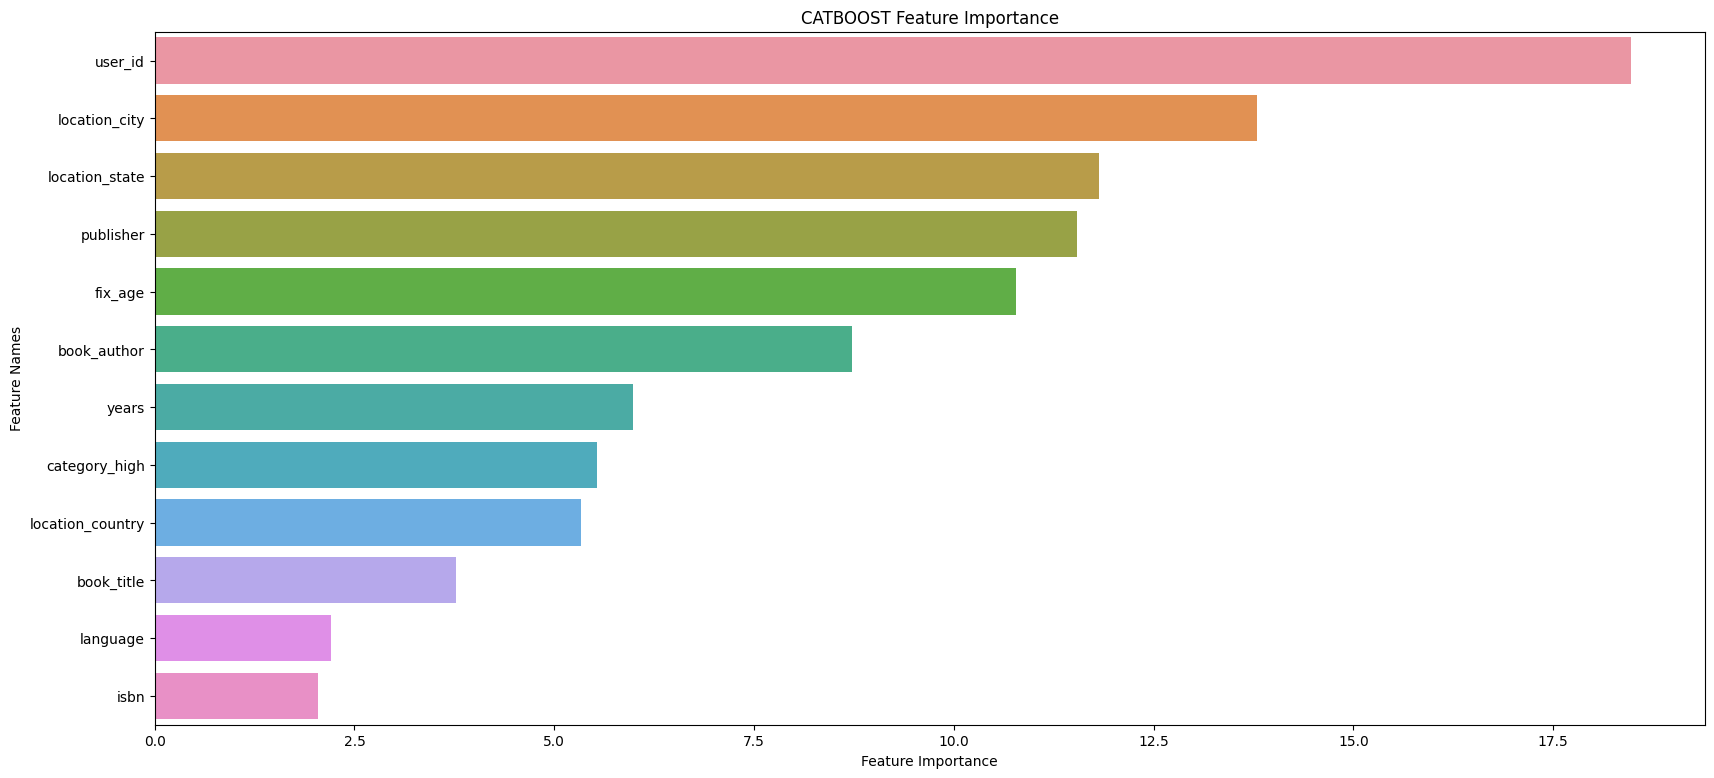

In [76]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')